In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
allocs = pd.Series([.3, .3, .35, .05, 1], index=['ES','NQ', 'GC', 'CL', 'total'])
#allocs = pd.Series([2/3, 1/3, 1], index=['ES','NQ', 'total'])
cash = 100000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-03-14_14-29_20180401_20181231_no_adjustments_GC2.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])

In [4]:
df.groupby('contract').realizedPNL.sum()

contract
CL    -7074.60
ES    16542.80
GC    -6814.24
NQ    54179.20
Name: realizedPNL, dtype: float64

In [5]:
df.realizedPNL.sum()

56833.159999999996

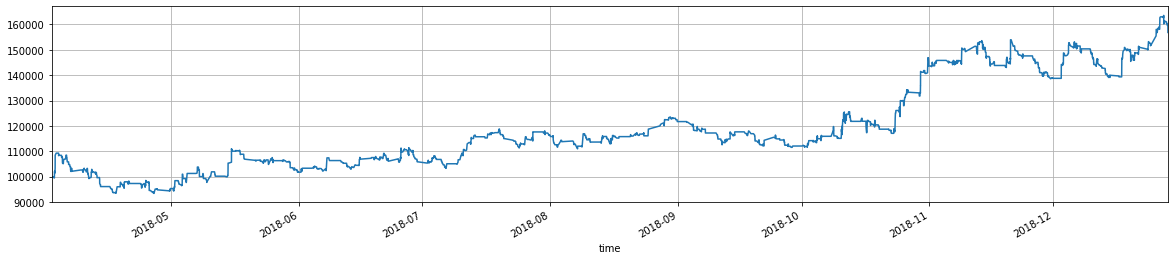

In [6]:
df.cash.plot(figsize=(20,4), grid=True);

In [7]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [8]:
# number of trades
trades = df.groupby('contract').action.count()
trades

contract
CL     580
ES     216
GC     536
NQ    1074
Name: action, dtype: int64

In [9]:
# commission paid
df.groupby('contract').commission.sum()

contract
CL    1374.60
ES     907.20
GC    2594.24
NQ    4510.80
Name: commission, dtype: float64

In [10]:
df.commission.sum()

9386.84

In [11]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
CL,0.34,-24.40,590.57,-338.28,1.75,-22.47,290.0
GC,0.35,-25.43,759.57,-442.59,1.72,-21.83,268.0
NQ,0.42,100.89,922.54,-487.12,1.89,104.94,537.0
ES,0.43,153.17,2056.27,-1258.80,1.63,166.68,108.0
total,0.38,47.24,932.22,-502.59,1.85,42.64,1203.0


In [12]:
daily = by_contract.resample('B').sum()
daily = daily.cumsum() +  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [13]:
# instrument correlations
log_returns = np.log(daily.pct_change()[1:] + 1)
log_returns.corr()

,CL,ES,GC,NQ,total
CL,1.000000,-0.122949,-0.014554,-0.168805,-0.095668
ES,-0.122949,1.000000,-0.128622,0.193312,0.652289
GC,-0.014554,-0.128622,1.000000,0.054206,0.381555
NQ,-0.168805,0.193312,0.054206,1.000000,0.661402
total,-0.095668,0.652289,0.381555,0.661402,1.000000


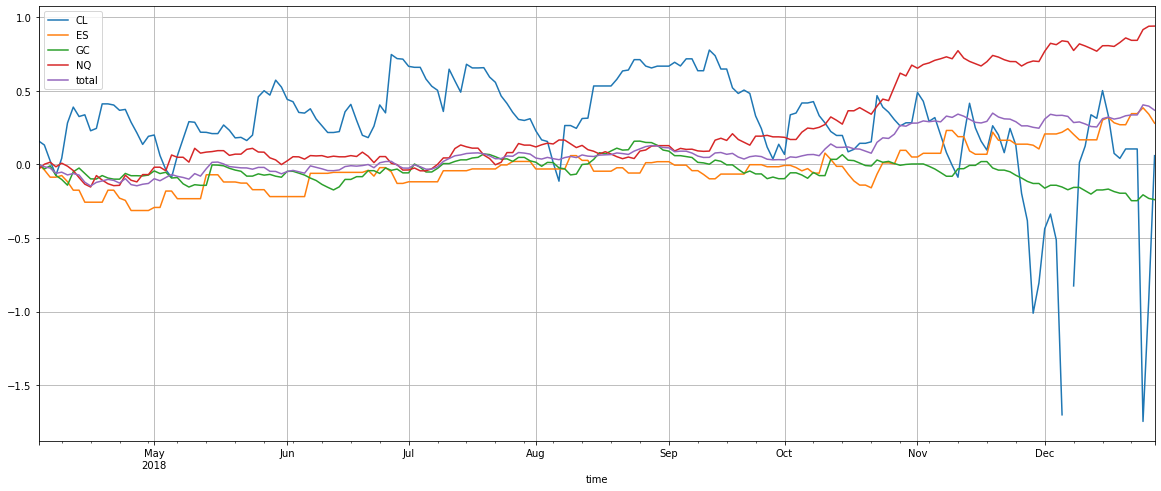

In [14]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

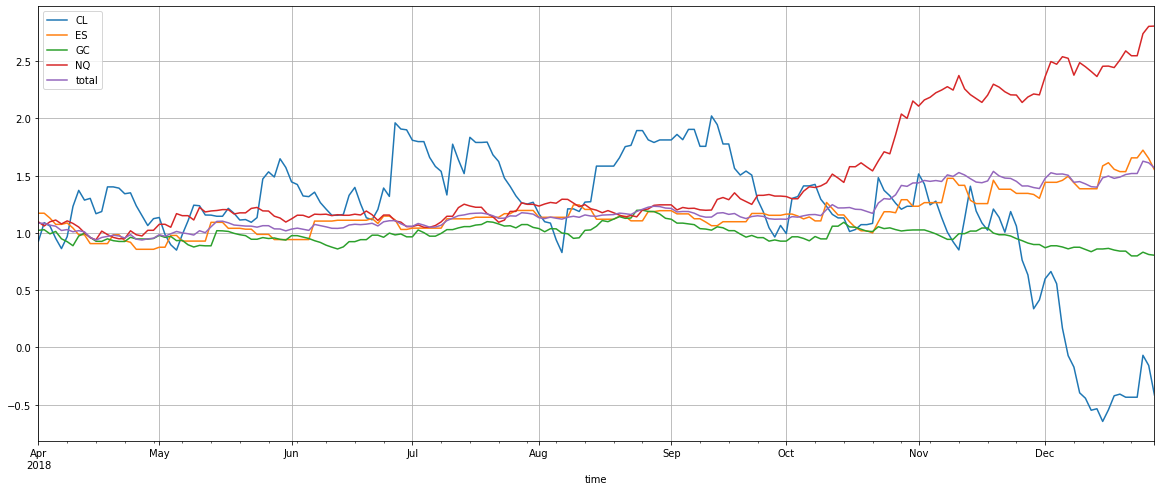

In [15]:
returns = daily.pct_change()
returns.iloc[0] = (daily.iloc[0] / (allocs * cash))-1
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [16]:
stats = pd.DataFrame()
for col in returns.columns:
    stats[col] = perf_stats(returns[col])
stats

,CL,ES,GC,NQ,total
Annual return,NaN,0.763939,-0.244084,2.793690,0.788817
Cumulative returns,-1.414920,0.551427,-0.194693,1.805973,0.568332
Annual volatility,4.286644,0.697909,0.430217,0.522231,0.338164
Sharpe ratio,1.081317,1.143493,-0.441855,2.813203,1.887017
Calmar ratio,NaN,2.842630,-0.733256,18.022495,5.790387
Stability,NaN,0.687811,0.013697,0.775999,0.840861
Max drawdown,-1.319394,-0.268744,-0.332877,-0.155011,-0.136229
Omega ratio,1.349026,1.326448,0.922146,1.638163,1.399076
Sortino ratio,2.006780,2.337327,-0.752333,5.797635,3.627939
Skew,1.970752,1.879303,1.700148,0.964994,1.124178


In [17]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,CL,ES,GC,NQ,total
time,,,,,
2018-04-30,21.06,-26.87,-6.95,-6.65,-12.12
2018-05-31,39.73,9.91,-1.47,7.03,6.77
2018-06-30,20.92,9.37,3.01,-3.67,4.00
2018-07-31,-33.29,16.09,8.51,18.49,9.96
2018-08-31,42.93,-0.16,7.61,-0.36,4.57
2018-09-30,-41.20,-3.37,-17.71,6.15,-7.91
2018-10-31,15.72,6.86,10.53,62.80,28.13
2018-11-30,-66.33,5.61,-12.40,2.48,-3.39
2018-12-31,137.57,19.13,-10.40,27.23,13.02


In [18]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

CL         6.0
ES        32.0
GC       -21.0
NQ       156.0
total     45.0
dtype: float64

In [19]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2018-11-08 20:42:00,ES,SELL,2795.75,6366.6
2018-11-20 16:38:00,ES,BUY,2657.00,6116.6
2018-12-17 16:56:00,ES,BUY,2594.25,5991.6
2018-10-31 15:48:00,NQ,SELL,6990.75,5951.6
2018-12-03 00:26:00,NQ,SELL,7085.25,5461.6
...,...,...,...,...
2018-12-27 21:11:00,ES,BUY,2430.75,-2183.4
2018-10-11 17:49:00,ES,BUY,2770.25,-2208.4
2018-11-21 08:31:00,ES,BUY,2656.00,-2358.4
